## Personalized Learning (Localized Learning?)

#### This notebook includes the following online models;
1. A single global model with all data
2. Multiple local models (starting from a single global model)
   1. that are updated with new data
   2. that exchanges data in clusters
   3. that exchanges parameters in clusters

  
#### The dataset that is used for this project is [CIFAR-100 dataset][1]
* Has 100 classes containing 600 images each

#### New data are fed by the following rules;
1. Distributed, according to superclasses
  * Clusters will only be updated with data that belongs to a specific superclass
  * We update the NN by
    1. Changing all parameters of the NN
    2. Only changing the last few layers, as in many MTL models
2. Randomly (why?)

#### We expect to find an answer to the following research questions with this project;
1. If models are updated with data (or parameters) that are shared within a cluster, can the model perform good enough with the labels that count?
  * For example, the performance of the cluster that are updated with "Vehicles" superclass is only assessed with the labels that corresponds to the superclass.
  
[1]: https://www.cs.toronto.edu/~kriz/cifar.html

#### Questions

Retraining: how does it work <br>
How do we compare these models?


### Implementation with Custom Neural Network and EMNIST dataset

In [25]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [26]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [27]:
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [28]:
tf.__version__

'1.15.0'

In [29]:
# Hyperparameters
batch_size = 50
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

#### Load MNIST dataset

In [30]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [31]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [32]:
x_train.shape

(60000, 28, 28, 1)

In [33]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [34]:
global_dataset_size = 30000
local_dataset_size = 30000

In [35]:
X_global = x_train[-global_dataset_size:]
Y_global = y_train[-global_dataset_size:]
X_local = x_train[:-global_dataset_size]
Y_local = y_train[:-global_dataset_size]

In [36]:
len(np.unique(y_train))

10

In [37]:
import utils

In [38]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/seth/projects/fed-learn-experiment/utils.py'>

In [39]:
X_local_list, Y_local_list = utils.split_training_set(1500, 20, X_local, Y_local)

In [40]:
# convert class vectors to binary class matrices
num_classes = 10
Y_global = keras.utils.to_categorical(Y_global, num_classes)

In [41]:
y_test = keras.utils.to_categorical(y_test, num_classes)

In [42]:
x_test.shape

(10000, 28, 28, 1)

### Define models and compile & fit function

In [43]:
def custom_model():
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [44]:
def compile_model(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [45]:
def compile_model_lr(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [46]:
def fit_model_global(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(X_global, Y_global,
                      batch_size=100,
                      epochs=40,
                      shuffle=True)

In [47]:
def fit_model_with_datasets(model, epochs, x_train, y_train):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    res =  model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True, validation_split=0.1)
    print ("Elasped Time: " + str(datetime.datetime.now() - now))
    return res

In [86]:
model1 = custom_model()
compile_model(model1)
fit_model_with_datasets(model1, 0, X_global, Y_global)

Training date and time : 
2020-04-25 21:32:58
Train on 27000 samples, validate on 3000 samples
Elasped Time: 0:00:00.036891


In [49]:
model_list = list()
for _ in range(20):
    model_list.append(tf.keras.models.clone_model(model1)) 
    model_list[_].set_weights(model1.get_weights())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [50]:
# sort models according to similarity. We arbitrarily take the model1 as a "standard"
standard_model = tf.keras.models.clone_model(model1)
standard_model.set_weights(model_list[0].get_weights())

In [51]:
import semantic_drift

In [52]:
importlib.reload(semantic_drift)

<module 'semantic_drift' from '/home/seth/projects/fed-learn-experiment/semantic_drift.py'>

### Conduct transfer learning in local models using different datasets & epochs


In [53]:
for i in range(len(model_list)):
    compile_model(model_list[i])
    fit_model_with_datasets(model_list[i], (i+1)*10, X_local_list[i], Y_local_list[i])

Training date and time : 
2020-04-25 21:07:47
Train on 1350 samples, validate on 150 samples
Epoch 1/10
1350/1350 [==============================] - 0s 101us/sample - loss: 0.0689 - acc: 0.5333 - val_loss: 0.0667 - val_acc: 0.5267
Epoch 2/10
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0667 - acc: 0.5407 - val_loss: 0.0647 - val_acc: 0.5400
Epoch 3/10
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0645 - acc: 0.5533 - val_loss: 0.0628 - val_acc: 0.5667
Epoch 4/10
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0624 - acc: 0.5674 - val_loss: 0.0609 - val_acc: 0.5800
Epoch 5/10
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0603 - acc: 0.5785 - val_loss: 0.0590 - val_acc: 0.5867
Epoch 6/10
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0582 - acc: 0.5970 - val_loss: 0.0571 - val_acc: 0.6200
Epoch 7/10
1350/1350 [==============================] - 0s 31us/sample - loss: 0.056

1350/1350 [==============================] - 0s 30us/sample - loss: 0.0236 - acc: 0.8896 - val_loss: 0.0284 - val_acc: 0.8467
Epoch 29/30
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0229 - acc: 0.8941 - val_loss: 0.0278 - val_acc: 0.8533
Epoch 30/30
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0223 - acc: 0.8956 - val_loss: 0.0270 - val_acc: 0.8600
Elasped Time: 0:00:01.524528
Training date and time : 
2020-04-25 21:07:50
Train on 1350 samples, validate on 150 samples
Epoch 1/40
1350/1350 [==============================] - 0s 114us/sample - loss: 0.0662 - acc: 0.5600 - val_loss: 0.0666 - val_acc: 0.5667
Epoch 2/40
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0638 - acc: 0.5667 - val_loss: 0.0643 - val_acc: 0.5933
Epoch 3/40
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0614 - acc: 0.5822 - val_loss: 0.0619 - val_acc: 0.6133
Epoch 4/40
1350/1350 [==============================] - 0s 35us/

Epoch 16/50
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0373 - acc: 0.8178 - val_loss: 0.0421 - val_acc: 0.8067
Epoch 17/50
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0359 - acc: 0.8304 - val_loss: 0.0406 - val_acc: 0.8267
Epoch 18/50
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0345 - acc: 0.8326 - val_loss: 0.0393 - val_acc: 0.8267
Epoch 19/50
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0332 - acc: 0.8452 - val_loss: 0.0382 - val_acc: 0.8267
Epoch 20/50
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0320 - acc: 0.8459 - val_loss: 0.0372 - val_acc: 0.8200
Epoch 21/50
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0309 - acc: 0.8533 - val_loss: 0.0362 - val_acc: 0.8200
Epoch 22/50
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0299 - acc: 0.8615 - val_loss: 0.0352 - val_acc: 0.8133
Epoch 23/50
1350/1350 [===========

1350/1350 [==============================] - 0s 30us/sample - loss: 0.0319 - acc: 0.8244 - val_loss: 0.0372 - val_acc: 0.7600
Epoch 25/60
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0310 - acc: 0.8304 - val_loss: 0.0366 - val_acc: 0.7533
Epoch 26/60
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0302 - acc: 0.8370 - val_loss: 0.0361 - val_acc: 0.7667
Epoch 27/60
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0294 - acc: 0.8407 - val_loss: 0.0357 - val_acc: 0.7600
Epoch 28/60
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0287 - acc: 0.8526 - val_loss: 0.0352 - val_acc: 0.7667
Epoch 29/60
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0279 - acc: 0.8600 - val_loss: 0.0347 - val_acc: 0.7533
Epoch 30/60
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0272 - acc: 0.8630 - val_loss: 0.0341 - val_acc: 0.7600
Epoch 31/60
1350/1350 [=======================

1350/1350 [==============================] - 0s 30us/sample - loss: 0.0283 - acc: 0.8659 - val_loss: 0.0259 - val_acc: 0.8800
Epoch 23/70
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0274 - acc: 0.8696 - val_loss: 0.0250 - val_acc: 0.8800
Epoch 24/70
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0265 - acc: 0.8719 - val_loss: 0.0242 - val_acc: 0.8933
Epoch 25/70
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0257 - acc: 0.8770 - val_loss: 0.0235 - val_acc: 0.8867
Epoch 26/70
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0250 - acc: 0.8763 - val_loss: 0.0228 - val_acc: 0.9000
Epoch 27/70
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0242 - acc: 0.8800 - val_loss: 0.0223 - val_acc: 0.8933
Epoch 28/70
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0236 - acc: 0.8807 - val_loss: 0.0217 - val_acc: 0.9000
Epoch 29/70
1350/1350 [=======================

1350/1350 [==============================] - 0s 31us/sample - loss: 0.0473 - acc: 0.7481 - val_loss: 0.0528 - val_acc: 0.6733
Epoch 11/80
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0453 - acc: 0.7704 - val_loss: 0.0508 - val_acc: 0.7000
Epoch 12/80
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0433 - acc: 0.7941 - val_loss: 0.0489 - val_acc: 0.7200
Epoch 13/80
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0415 - acc: 0.8104 - val_loss: 0.0472 - val_acc: 0.7333
Epoch 14/80
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0396 - acc: 0.8215 - val_loss: 0.0454 - val_acc: 0.7467
Epoch 15/80
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0379 - acc: 0.8356 - val_loss: 0.0437 - val_acc: 0.7533
Epoch 16/80
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0363 - acc: 0.8378 - val_loss: 0.0422 - val_acc: 0.7667
Epoch 17/80
1350/1350 [=======================

1350/1350 [==============================] - 0s 31us/sample - loss: 0.0117 - acc: 0.9459 - val_loss: 0.0186 - val_acc: 0.8933
Epoch 70/80
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0116 - acc: 0.9481 - val_loss: 0.0183 - val_acc: 0.9000
Epoch 71/80
1350/1350 [==============================] - 0s 34us/sample - loss: 0.0114 - acc: 0.9467 - val_loss: 0.0182 - val_acc: 0.8933
Epoch 72/80
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0113 - acc: 0.9504 - val_loss: 0.0183 - val_acc: 0.8933
Epoch 73/80
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0112 - acc: 0.9467 - val_loss: 0.0181 - val_acc: 0.9000
Epoch 74/80
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0110 - acc: 0.9481 - val_loss: 0.0181 - val_acc: 0.8933
Epoch 75/80
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0109 - acc: 0.9511 - val_loss: 0.0179 - val_acc: 0.8933
Epoch 76/80
1350/1350 [=======================

1350/1350 [==============================] - 0s 29us/sample - loss: 0.0188 - acc: 0.8956 - val_loss: 0.0187 - val_acc: 0.9067
Epoch 48/90
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0186 - acc: 0.8978 - val_loss: 0.0186 - val_acc: 0.9067
Epoch 49/90
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0184 - acc: 0.9007 - val_loss: 0.0183 - val_acc: 0.9067
Epoch 50/90
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0181 - acc: 0.9022 - val_loss: 0.0180 - val_acc: 0.9067
Epoch 51/90
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0178 - acc: 0.9037 - val_loss: 0.0178 - val_acc: 0.9067
Epoch 52/90
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0176 - acc: 0.9037 - val_loss: 0.0180 - val_acc: 0.9067
Epoch 53/90
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0174 - acc: 0.9052 - val_loss: 0.0180 - val_acc: 0.9067
Epoch 54/90
1350/1350 [=======================

1350/1350 [==============================] - 0s 31us/sample - loss: 0.0445 - acc: 0.7563 - val_loss: 0.0433 - val_acc: 0.7533
Epoch 16/100
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0429 - acc: 0.7756 - val_loss: 0.0418 - val_acc: 0.7667
Epoch 17/100
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0414 - acc: 0.7896 - val_loss: 0.0404 - val_acc: 0.7733
Epoch 18/100
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0401 - acc: 0.7993 - val_loss: 0.0391 - val_acc: 0.7933
Epoch 19/100
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0388 - acc: 0.8104 - val_loss: 0.0379 - val_acc: 0.8133
Epoch 20/100
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0375 - acc: 0.8244 - val_loss: 0.0367 - val_acc: 0.8133
Epoch 21/100
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0363 - acc: 0.8230 - val_loss: 0.0357 - val_acc: 0.8133
Epoch 22/100
1350/1350 [================

1350/1350 [==============================] - 0s 31us/sample - loss: 0.0146 - acc: 0.9281 - val_loss: 0.0198 - val_acc: 0.8600
Epoch 75/100
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0144 - acc: 0.9267 - val_loss: 0.0197 - val_acc: 0.8600
Epoch 76/100
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0143 - acc: 0.9267 - val_loss: 0.0195 - val_acc: 0.8667
Epoch 77/100
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0142 - acc: 0.9274 - val_loss: 0.0197 - val_acc: 0.8600
Epoch 78/100
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0140 - acc: 0.9296 - val_loss: 0.0196 - val_acc: 0.8667
Epoch 79/100
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0139 - acc: 0.9289 - val_loss: 0.0193 - val_acc: 0.8667
Epoch 80/100
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0138 - acc: 0.9319 - val_loss: 0.0193 - val_acc: 0.8667
Epoch 81/100
1350/1350 [================

1350/1350 [==============================] - 0s 31us/sample - loss: 0.0236 - acc: 0.8874 - val_loss: 0.0238 - val_acc: 0.8800
Epoch 33/110
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0230 - acc: 0.8896 - val_loss: 0.0233 - val_acc: 0.8867
Epoch 34/110
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0225 - acc: 0.8896 - val_loss: 0.0230 - val_acc: 0.8933
Epoch 35/110
1350/1350 [==============================] - 0s 34us/sample - loss: 0.0220 - acc: 0.8919 - val_loss: 0.0226 - val_acc: 0.8867
Epoch 36/110
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0215 - acc: 0.8956 - val_loss: 0.0223 - val_acc: 0.8867
Epoch 37/110
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0210 - acc: 0.8948 - val_loss: 0.0218 - val_acc: 0.8800
Epoch 38/110
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0206 - acc: 0.8956 - val_loss: 0.0217 - val_acc: 0.8867
Epoch 39/110
1350/1350 [================

1350/1350 [==============================] - 0s 29us/sample - loss: 0.0100 - acc: 0.9548 - val_loss: 0.0157 - val_acc: 0.9000
Epoch 92/110
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0098 - acc: 0.9548 - val_loss: 0.0157 - val_acc: 0.8933
Epoch 93/110
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0098 - acc: 0.9578 - val_loss: 0.0155 - val_acc: 0.9000
Epoch 94/110
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0097 - acc: 0.9570 - val_loss: 0.0156 - val_acc: 0.9000
Epoch 95/110
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0096 - acc: 0.9570 - val_loss: 0.0155 - val_acc: 0.9000
Epoch 96/110
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0095 - acc: 0.9578 - val_loss: 0.0155 - val_acc: 0.9000
Epoch 97/110
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0094 - acc: 0.9585 - val_loss: 0.0153 - val_acc: 0.8933
Epoch 98/110
1350/1350 [================

1350/1350 [==============================] - 0s 29us/sample - loss: 0.0225 - acc: 0.8785 - val_loss: 0.0240 - val_acc: 0.8733
Epoch 40/120
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0222 - acc: 0.8793 - val_loss: 0.0238 - val_acc: 0.8733
Epoch 41/120
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0218 - acc: 0.8822 - val_loss: 0.0235 - val_acc: 0.8800
Epoch 42/120
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0215 - acc: 0.8830 - val_loss: 0.0233 - val_acc: 0.8800
Epoch 43/120
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0211 - acc: 0.8867 - val_loss: 0.0229 - val_acc: 0.8733
Epoch 44/120
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0208 - acc: 0.8867 - val_loss: 0.0230 - val_acc: 0.8733
Epoch 45/120
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0206 - acc: 0.8889 - val_loss: 0.0226 - val_acc: 0.8733
Epoch 46/120
1350/1350 [================

1350/1350 [==============================] - 0s 30us/sample - loss: 0.0124 - acc: 0.9289 - val_loss: 0.0170 - val_acc: 0.8800
Epoch 99/120
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0123 - acc: 0.9296 - val_loss: 0.0167 - val_acc: 0.8800
Epoch 100/120
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0122 - acc: 0.9326 - val_loss: 0.0167 - val_acc: 0.8800
Epoch 101/120
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0121 - acc: 0.9348 - val_loss: 0.0170 - val_acc: 0.8867
Epoch 102/120
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0121 - acc: 0.9333 - val_loss: 0.0167 - val_acc: 0.8867
Epoch 103/120
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0119 - acc: 0.9348 - val_loss: 0.0169 - val_acc: 0.8867
Epoch 104/120
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0119 - acc: 0.9341 - val_loss: 0.0167 - val_acc: 0.8800
Epoch 105/120
1350/1350 [==========

1350/1350 [==============================] - 0s 32us/sample - loss: 0.0188 - acc: 0.9178 - val_loss: 0.0222 - val_acc: 0.8400
Epoch 37/130
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0184 - acc: 0.9156 - val_loss: 0.0218 - val_acc: 0.8533
Epoch 38/130
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0180 - acc: 0.9170 - val_loss: 0.0216 - val_acc: 0.8400
Epoch 39/130
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0176 - acc: 0.9200 - val_loss: 0.0214 - val_acc: 0.8600
Epoch 40/130
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0172 - acc: 0.9230 - val_loss: 0.0212 - val_acc: 0.8467
Epoch 41/130
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0169 - acc: 0.9252 - val_loss: 0.0210 - val_acc: 0.8467
Epoch 42/130
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0166 - acc: 0.9244 - val_loss: 0.0210 - val_acc: 0.8400
Epoch 43/130
1350/1350 [================

1350/1350 [==============================] - 0s 31us/sample - loss: 0.0083 - acc: 0.9630 - val_loss: 0.0193 - val_acc: 0.8533
Epoch 96/130
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0082 - acc: 0.9644 - val_loss: 0.0193 - val_acc: 0.8533
Epoch 97/130
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0081 - acc: 0.9630 - val_loss: 0.0194 - val_acc: 0.8533
Epoch 98/130
1350/1350 [==============================] - 0s 35us/sample - loss: 0.0080 - acc: 0.9644 - val_loss: 0.0193 - val_acc: 0.8600
Epoch 99/130
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0079 - acc: 0.9674 - val_loss: 0.0193 - val_acc: 0.8600
Epoch 100/130
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0079 - acc: 0.9674 - val_loss: 0.0192 - val_acc: 0.8533
Epoch 101/130
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0078 - acc: 0.9667 - val_loss: 0.0193 - val_acc: 0.8600
Epoch 102/130
1350/1350 [=============

Epoch 23/140
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0269 - acc: 0.8822 - val_loss: 0.0382 - val_acc: 0.7867
Epoch 24/140
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0260 - acc: 0.8904 - val_loss: 0.0375 - val_acc: 0.8000
Epoch 25/140
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0252 - acc: 0.8881 - val_loss: 0.0370 - val_acc: 0.8000
Epoch 26/140
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0245 - acc: 0.8948 - val_loss: 0.0361 - val_acc: 0.8000
Epoch 27/140
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0238 - acc: 0.8970 - val_loss: 0.0356 - val_acc: 0.8133
Epoch 28/140
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0232 - acc: 0.8970 - val_loss: 0.0354 - val_acc: 0.8000
Epoch 29/140
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0226 - acc: 0.9000 - val_loss: 0.0348 - val_acc: 0.8067
Epoch 30/140
1350/1350 [===

Epoch 82/140
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0107 - acc: 0.9504 - val_loss: 0.0258 - val_acc: 0.8467
Epoch 83/140
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0106 - acc: 0.9489 - val_loss: 0.0254 - val_acc: 0.8467
Epoch 84/140
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0105 - acc: 0.9496 - val_loss: 0.0255 - val_acc: 0.8467
Epoch 85/140
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0104 - acc: 0.9519 - val_loss: 0.0253 - val_acc: 0.8467
Epoch 86/140
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0103 - acc: 0.9526 - val_loss: 0.0254 - val_acc: 0.8467
Epoch 87/140
1350/1350 [==============================] - 0s 33us/sample - loss: 0.0103 - acc: 0.9511 - val_loss: 0.0254 - val_acc: 0.8400
Epoch 88/140
1350/1350 [==============================] - 0s 34us/sample - loss: 0.0102 - acc: 0.9519 - val_loss: 0.0253 - val_acc: 0.8467
Epoch 89/140
1350/1350 [===

1350/1350 [==============================] - 0s 29us/sample - loss: 0.0071 - acc: 0.9659 - val_loss: 0.0240 - val_acc: 0.8600
Elasped Time: 0:00:06.444142
Training date and time : 
2020-04-25 21:08:36
Train on 1350 samples, validate on 150 samples
Epoch 1/150
1350/1350 [==============================] - 0s 143us/sample - loss: 0.0681 - acc: 0.5452 - val_loss: 0.0678 - val_acc: 0.6000
Epoch 2/150
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0656 - acc: 0.5652 - val_loss: 0.0657 - val_acc: 0.6067
Epoch 3/150
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0631 - acc: 0.5770 - val_loss: 0.0636 - val_acc: 0.6200
Epoch 4/150
1350/1350 [==============================] - 0s 33us/sample - loss: 0.0606 - acc: 0.5941 - val_loss: 0.0615 - val_acc: 0.6333
Epoch 5/150
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0580 - acc: 0.6193 - val_loss: 0.0595 - val_acc: 0.6533
Epoch 6/150
1350/1350 [==============================] - 0s 3

1350/1350 [==============================] - 0s 30us/sample - loss: 0.0123 - acc: 0.9393 - val_loss: 0.0238 - val_acc: 0.8333
Epoch 59/150
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0122 - acc: 0.9393 - val_loss: 0.0235 - val_acc: 0.8400
Epoch 60/150
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0120 - acc: 0.9393 - val_loss: 0.0231 - val_acc: 0.8267
Epoch 61/150
1350/1350 [==============================] - 0s 33us/sample - loss: 0.0118 - acc: 0.9430 - val_loss: 0.0231 - val_acc: 0.8400
Epoch 62/150
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0116 - acc: 0.9400 - val_loss: 0.0231 - val_acc: 0.8467
Epoch 63/150
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0115 - acc: 0.9452 - val_loss: 0.0229 - val_acc: 0.8533
Epoch 64/150
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0114 - acc: 0.9452 - val_loss: 0.0227 - val_acc: 0.8467
Epoch 65/150
1350/1350 [================

Epoch 117/150
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0067 - acc: 0.9704 - val_loss: 0.0189 - val_acc: 0.8400
Epoch 118/150
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0067 - acc: 0.9711 - val_loss: 0.0189 - val_acc: 0.8400
Epoch 119/150
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0066 - acc: 0.9704 - val_loss: 0.0187 - val_acc: 0.8467
Epoch 120/150
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0066 - acc: 0.9704 - val_loss: 0.0188 - val_acc: 0.8400
Epoch 121/150
1350/1350 [==============================] - 0s 28us/sample - loss: 0.0065 - acc: 0.9704 - val_loss: 0.0186 - val_acc: 0.8467
Epoch 122/150
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0065 - acc: 0.9704 - val_loss: 0.0188 - val_acc: 0.8467
Epoch 123/150
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0064 - acc: 0.9704 - val_loss: 0.0186 - val_acc: 0.8533
Epoch 124/150
1350/1

Epoch 25/160
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0278 - acc: 0.8644 - val_loss: 0.0329 - val_acc: 0.8333
Epoch 26/160
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0269 - acc: 0.8659 - val_loss: 0.0322 - val_acc: 0.8467
Epoch 27/160
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0262 - acc: 0.8719 - val_loss: 0.0315 - val_acc: 0.8467
Epoch 28/160
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0255 - acc: 0.8807 - val_loss: 0.0311 - val_acc: 0.8467
Epoch 29/160
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0247 - acc: 0.8822 - val_loss: 0.0303 - val_acc: 0.8400
Epoch 30/160
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0241 - acc: 0.8881 - val_loss: 0.0302 - val_acc: 0.8533
Epoch 31/160
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0235 - acc: 0.8874 - val_loss: 0.0294 - val_acc: 0.8400
Epoch 32/160
1350/1350 [===

Epoch 84/160
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0104 - acc: 0.9533 - val_loss: 0.0203 - val_acc: 0.8400
Epoch 85/160
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0103 - acc: 0.9533 - val_loss: 0.0200 - val_acc: 0.8533
Epoch 86/160
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0101 - acc: 0.9533 - val_loss: 0.0200 - val_acc: 0.8467
Epoch 87/160
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0100 - acc: 0.9541 - val_loss: 0.0198 - val_acc: 0.8600
Epoch 88/160
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0099 - acc: 0.9548 - val_loss: 0.0199 - val_acc: 0.8533
Epoch 89/160
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0098 - acc: 0.9548 - val_loss: 0.0199 - val_acc: 0.8467
Epoch 90/160
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0097 - acc: 0.9556 - val_loss: 0.0200 - val_acc: 0.8467
Epoch 91/160
1350/1350 [===

1350/1350 [==============================] - 0s 30us/sample - loss: 0.0060 - acc: 0.9748 - val_loss: 0.0190 - val_acc: 0.8733
Epoch 143/160
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0060 - acc: 0.9748 - val_loss: 0.0191 - val_acc: 0.8533
Epoch 144/160
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0059 - acc: 0.9756 - val_loss: 0.0190 - val_acc: 0.8733
Epoch 145/160
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0059 - acc: 0.9748 - val_loss: 0.0191 - val_acc: 0.8733
Epoch 146/160
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0058 - acc: 0.9756 - val_loss: 0.0190 - val_acc: 0.8800
Epoch 147/160
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0058 - acc: 0.9763 - val_loss: 0.0191 - val_acc: 0.8667
Epoch 148/160
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0058 - acc: 0.9763 - val_loss: 0.0191 - val_acc: 0.8733
Epoch 149/160
1350/1350 [=========

1350/1350 [==============================] - 0s 30us/sample - loss: 0.0202 - acc: 0.8970 - val_loss: 0.0170 - val_acc: 0.9133
Epoch 41/170
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0199 - acc: 0.8970 - val_loss: 0.0167 - val_acc: 0.9067
Epoch 42/170
1350/1350 [==============================] - 0s 33us/sample - loss: 0.0195 - acc: 0.8978 - val_loss: 0.0162 - val_acc: 0.9200
Epoch 43/170
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0191 - acc: 0.9015 - val_loss: 0.0163 - val_acc: 0.9200
Epoch 44/170
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0188 - acc: 0.8985 - val_loss: 0.0160 - val_acc: 0.9200
Epoch 45/170
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0185 - acc: 0.9037 - val_loss: 0.0159 - val_acc: 0.9267
Epoch 46/170
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0182 - acc: 0.9044 - val_loss: 0.0156 - val_acc: 0.9200
Epoch 47/170
1350/1350 [================

1350/1350 [==============================] - 0s 31us/sample - loss: 0.0093 - acc: 0.9593 - val_loss: 0.0113 - val_acc: 0.9267
Epoch 100/170
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0092 - acc: 0.9600 - val_loss: 0.0113 - val_acc: 0.9267
Epoch 101/170
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0091 - acc: 0.9593 - val_loss: 0.0113 - val_acc: 0.9267
Epoch 102/170
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0090 - acc: 0.9600 - val_loss: 0.0112 - val_acc: 0.9267
Epoch 103/170
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0090 - acc: 0.9607 - val_loss: 0.0112 - val_acc: 0.9267
Epoch 104/170
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0089 - acc: 0.9615 - val_loss: 0.0112 - val_acc: 0.9267
Epoch 105/170
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0088 - acc: 0.9615 - val_loss: 0.0112 - val_acc: 0.9267
Epoch 106/170
1350/1350 [=========

1350/1350 [==============================] - 0s 30us/sample - loss: 0.0056 - acc: 0.9800 - val_loss: 0.0101 - val_acc: 0.9333
Epoch 158/170
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0055 - acc: 0.9807 - val_loss: 0.0101 - val_acc: 0.9333
Epoch 159/170
1350/1350 [==============================] - 0s 34us/sample - loss: 0.0055 - acc: 0.9800 - val_loss: 0.0101 - val_acc: 0.9333
Epoch 160/170
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0054 - acc: 0.9815 - val_loss: 0.0101 - val_acc: 0.9333
Epoch 161/170
1350/1350 [==============================] - 0s 33us/sample - loss: 0.0054 - acc: 0.9815 - val_loss: 0.0101 - val_acc: 0.9333
Epoch 162/170
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0053 - acc: 0.9815 - val_loss: 0.0101 - val_acc: 0.9333
Epoch 163/170
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0053 - acc: 0.9815 - val_loss: 0.0101 - val_acc: 0.9333
Epoch 164/170
1350/1350 [=========

1350/1350 [==============================] - 0s 33us/sample - loss: 0.0160 - acc: 0.9230 - val_loss: 0.0246 - val_acc: 0.8400
Epoch 46/180
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0158 - acc: 0.9259 - val_loss: 0.0241 - val_acc: 0.8467
Epoch 47/180
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0155 - acc: 0.9274 - val_loss: 0.0242 - val_acc: 0.8400
Epoch 48/180
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0153 - acc: 0.9304 - val_loss: 0.0238 - val_acc: 0.8400
Epoch 49/180
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0150 - acc: 0.9281 - val_loss: 0.0237 - val_acc: 0.8467
Epoch 50/180
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0148 - acc: 0.9296 - val_loss: 0.0235 - val_acc: 0.8467
Epoch 51/180
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0146 - acc: 0.9311 - val_loss: 0.0235 - val_acc: 0.8533
Epoch 52/180
1350/1350 [================

1350/1350 [==============================] - 0s 31us/sample - loss: 0.0082 - acc: 0.9622 - val_loss: 0.0185 - val_acc: 0.9000
Epoch 105/180
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0081 - acc: 0.9615 - val_loss: 0.0183 - val_acc: 0.9000
Epoch 106/180
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0081 - acc: 0.9630 - val_loss: 0.0184 - val_acc: 0.8933
Epoch 107/180
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0080 - acc: 0.9615 - val_loss: 0.0184 - val_acc: 0.9000
Epoch 108/180
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0080 - acc: 0.9630 - val_loss: 0.0183 - val_acc: 0.9000
Epoch 109/180
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0079 - acc: 0.9644 - val_loss: 0.0183 - val_acc: 0.9000
Epoch 110/180
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0078 - acc: 0.9622 - val_loss: 0.0182 - val_acc: 0.9000
Epoch 111/180
1350/1350 [=========

1350/1350 [==============================] - 0s 33us/sample - loss: 0.0054 - acc: 0.9770 - val_loss: 0.0174 - val_acc: 0.9067
Epoch 163/180
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0053 - acc: 0.9770 - val_loss: 0.0175 - val_acc: 0.9067
Epoch 164/180
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0053 - acc: 0.9770 - val_loss: 0.0174 - val_acc: 0.9067
Epoch 165/180
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0053 - acc: 0.9770 - val_loss: 0.0174 - val_acc: 0.9067
Epoch 166/180
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0052 - acc: 0.9770 - val_loss: 0.0173 - val_acc: 0.9067
Epoch 167/180
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0052 - acc: 0.9778 - val_loss: 0.0174 - val_acc: 0.9067
Epoch 168/180
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0052 - acc: 0.9778 - val_loss: 0.0175 - val_acc: 0.9067
Epoch 169/180
1350/1350 [=========

1350/1350 [==============================] - 0s 30us/sample - loss: 0.0168 - acc: 0.9148 - val_loss: 0.0266 - val_acc: 0.8333
Epoch 41/190
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0165 - acc: 0.9156 - val_loss: 0.0266 - val_acc: 0.8200
Epoch 42/190
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0162 - acc: 0.9207 - val_loss: 0.0264 - val_acc: 0.8267
Epoch 43/190
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0159 - acc: 0.9178 - val_loss: 0.0262 - val_acc: 0.8200
Epoch 44/190
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0156 - acc: 0.9207 - val_loss: 0.0259 - val_acc: 0.8333
Epoch 45/190
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0153 - acc: 0.9215 - val_loss: 0.0259 - val_acc: 0.8267
Epoch 46/190
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0150 - acc: 0.9222 - val_loss: 0.0257 - val_acc: 0.8333
Epoch 47/190
1350/1350 [================

1350/1350 [==============================] - 0s 31us/sample - loss: 0.0082 - acc: 0.9578 - val_loss: 0.0214 - val_acc: 0.8667
Epoch 100/190
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0081 - acc: 0.9593 - val_loss: 0.0215 - val_acc: 0.8667
Epoch 101/190
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0080 - acc: 0.9607 - val_loss: 0.0213 - val_acc: 0.8667
Epoch 102/190
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0080 - acc: 0.9593 - val_loss: 0.0215 - val_acc: 0.8667
Epoch 103/190
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0079 - acc: 0.9600 - val_loss: 0.0214 - val_acc: 0.8667
Epoch 104/190
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0079 - acc: 0.9600 - val_loss: 0.0215 - val_acc: 0.8667
Epoch 105/190
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0078 - acc: 0.9615 - val_loss: 0.0215 - val_acc: 0.8667
Epoch 106/190
1350/1350 [=========

1350/1350 [==============================] - 0s 31us/sample - loss: 0.0052 - acc: 0.9785 - val_loss: 0.0195 - val_acc: 0.8733
Epoch 158/190
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0052 - acc: 0.9785 - val_loss: 0.0196 - val_acc: 0.8733
Epoch 159/190
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0052 - acc: 0.9770 - val_loss: 0.0196 - val_acc: 0.8733
Epoch 160/190
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0051 - acc: 0.9793 - val_loss: 0.0194 - val_acc: 0.8733
Epoch 161/190
1350/1350 [==============================] - 0s 34us/sample - loss: 0.0051 - acc: 0.9785 - val_loss: 0.0194 - val_acc: 0.8733
Epoch 162/190
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0050 - acc: 0.9793 - val_loss: 0.0194 - val_acc: 0.8800
Epoch 163/190
1350/1350 [==============================] - 0s 33us/sample - loss: 0.0050 - acc: 0.9800 - val_loss: 0.0192 - val_acc: 0.8800
Epoch 164/190
1350/1350 [=========

Epoch 25/200
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0287 - acc: 0.8585 - val_loss: 0.0420 - val_acc: 0.7667
Epoch 26/200
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0279 - acc: 0.8585 - val_loss: 0.0413 - val_acc: 0.7667
Epoch 27/200
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0272 - acc: 0.8600 - val_loss: 0.0405 - val_acc: 0.7733
Epoch 28/200
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0265 - acc: 0.8637 - val_loss: 0.0399 - val_acc: 0.7800
Epoch 29/200
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0259 - acc: 0.8652 - val_loss: 0.0393 - val_acc: 0.7800
Epoch 30/200
1350/1350 [==============================] - 0s 33us/sample - loss: 0.0253 - acc: 0.8652 - val_loss: 0.0387 - val_acc: 0.7867
Epoch 31/200
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0248 - acc: 0.8689 - val_loss: 0.0382 - val_acc: 0.7867
Epoch 32/200
1350/1350 [===

Epoch 84/200
1350/1350 [==============================] - 0s 34us/sample - loss: 0.0120 - acc: 0.9393 - val_loss: 0.0283 - val_acc: 0.8000
Epoch 85/200
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0119 - acc: 0.9385 - val_loss: 0.0283 - val_acc: 0.8000
Epoch 86/200
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0118 - acc: 0.9393 - val_loss: 0.0282 - val_acc: 0.8000
Epoch 87/200
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0116 - acc: 0.9422 - val_loss: 0.0285 - val_acc: 0.8000
Epoch 88/200
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0115 - acc: 0.9393 - val_loss: 0.0281 - val_acc: 0.8000
Epoch 89/200
1350/1350 [==============================] - 0s 30us/sample - loss: 0.0114 - acc: 0.9422 - val_loss: 0.0283 - val_acc: 0.8000
Epoch 90/200
1350/1350 [==============================] - 0s 29us/sample - loss: 0.0113 - acc: 0.9430 - val_loss: 0.0280 - val_acc: 0.8000
Epoch 91/200
1350/1350 [===

1350/1350 [==============================] - 0s 30us/sample - loss: 0.0072 - acc: 0.9659 - val_loss: 0.0266 - val_acc: 0.8067
Epoch 143/200
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0072 - acc: 0.9652 - val_loss: 0.0267 - val_acc: 0.8133
Epoch 144/200
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0072 - acc: 0.9652 - val_loss: 0.0268 - val_acc: 0.8067
Epoch 145/200
1350/1350 [==============================] - 0s 31us/sample - loss: 0.0071 - acc: 0.9667 - val_loss: 0.0269 - val_acc: 0.8067
Epoch 146/200
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0071 - acc: 0.9667 - val_loss: 0.0266 - val_acc: 0.8067
Epoch 147/200
1350/1350 [==============================] - 0s 32us/sample - loss: 0.0070 - acc: 0.9667 - val_loss: 0.0267 - val_acc: 0.8067
Epoch 148/200
1350/1350 [==============================] - 0s 33us/sample - loss: 0.0070 - acc: 0.9667 - val_loss: 0.0266 - val_acc: 0.8067
Epoch 149/200
1350/1350 [=========

1350/1350 [==============================] - 0s 31us/sample - loss: 0.0051 - acc: 0.9748 - val_loss: 0.0261 - val_acc: 0.8200
Elasped Time: 0:00:09.258416


### Let's see how these models are different from each other, compared to the base model(before training)


In [ ]:
model_list[0].get

In [64]:
l = [np.array(m.get_weights()) for m in model_list]

In [65]:
l = np.array(l)

In [73]:
av = np.average(l, axis=0)

In [81]:
av[1].shape

(200,)

In [79]:
l[1][2].shape

(200, 200)

In [72]:
l[2][0].shape

(784, 200)

In [83]:
avg_weight = np.average(np.array([np.array(m.get_weights()) for m in model_list]), axis=0)

In [85]:
model1.set_weights(avg_weight)

In [30]:
dists = [semantic_drift.l2_distance(standard_model, m) for m in model_list]
print(dists)

[0.72831976, 1.2300797, 1.6375992, 1.8042661, 2.101626, 2.2287998, 2.3368342, 2.5651116, 2.6788723, 2.932489, 2.9436498, 3.1036754, 3.1189368, 3.1189752, 3.233824, 3.4184306, 3.505584, 3.4839816, 3.4630003, 3.7790039]


In [31]:
model_list.sort(key=lambda m : semantic_drift.l2_distance(standard_model, m))

In [32]:
dists = [semantic_drift.l2_distance(standard_model, m) for m in model_list]
print(dists)

[0.72831976, 1.2300797, 1.6375992, 1.8042661, 2.101626, 2.2287998, 2.3368342, 2.5651116, 2.6788723, 2.932489, 2.9436498, 3.1036754, 3.1189368, 3.1189752, 3.233824, 3.4184306, 3.4630003, 3.4839816, 3.505584, 3.7790039]


In [33]:
theta_list = list(np.arange(0, 1.05, 0.05))

In [34]:
def model_combs(model_list):
    combs = list()
    l = len(model_list)
    for i in range(l):
        for j in range(l):
            if i > j:
                combs.append([model_list[i], model_list[j]])
    return combs

In [35]:
agg_weights_list_per_pi = list()
dist_list = list()
for model_comp in model_combs(model_list):
    if model_comp[0] is model_comp[1]:    #disregard same models
        continue
    weights = [model_comp[0].get_weights(), model_comp[1].get_weights()]
    agg_weights_list = list()
    for theta in theta_list:
        agg_weights = list()
        for weights_list_tuple in zip(*weights):
            agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
        agg_weights_list.append(agg_weights)
    dist_list.append(semantic_drift.l2_distance(model_comp[0], model_comp[1]))
    agg_weights_list_per_pi.append(agg_weights_list)

In [36]:
# this has to be nC_2
len(dist_list)

190

In [37]:
dist_list

[0.6790231,
 1.0674238,
 0.76220334,
 1.2572709,
 0.9291775,
 0.87450594,
 1.5597007,
 1.2231365,
 1.0425137,
 1.0706325,
 1.7077744,
 1.3930168,
 1.2464184,
 1.2036492,
 1.3275005,
 1.8415955,
 1.4904561,
 1.3264697,
 1.334568,
 1.2624314,
 1.4890555,
 2.0484147,
 1.6922038,
 1.4902464,
 1.448433,
 1.429275,
 1.5020276,
 1.5401735,
 2.1922908,
 1.8737718,
 1.6852325,
 1.6184423,
 1.668025,
 1.6669601,
 1.723613,
 1.7175785,
 2.4662292,
 2.1276922,
 1.9431642,
 1.8858895,
 1.8604085,
 1.9284871,
 1.8568151,
 1.9258292,
 2.0116045,
 2.44775,
 2.1112788,
 1.9144111,
 1.8178817,
 1.7878528,
 1.8373672,
 1.7802958,
 1.8183829,
 1.8848307,
 2.04441,
 2.630128,
 2.312654,
 2.0886657,
 2.0123613,
 1.9700245,
 1.918427,
 1.9843751,
 1.9962378,
 2.015119,
 2.115679,
 2.0416331,
 2.6332684,
 2.274623,
 2.0428298,
 1.9744081,
 1.8964151,
 1.915635,
 1.9040977,
 1.8982803,
 1.9788328,
 2.0905643,
 1.9930409,
 2.0892036,
 2.651401,
 2.3060958,
 2.0930645,
 2.0427055,
 2.0135384,
 2.0219011,
 2.0162

In [38]:
agg_weights_list_per_pi_sorted = [x for _,x in sorted(zip(dist_list,agg_weights_list_per_pi))]

In [39]:
X, Y = np.meshgrid(np.array(theta_list), np.array(sorted(dist_list)))
Z = np.zeros(X.shape)

In [40]:
a = 1

In [41]:
i = 0
for agg_weights_list in agg_weights_list_per_pi_sorted:
    j = 0
    for agg_weights in agg_weights_list:
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights)
        compile_model(aggr_model)
        score = aggr_model.evaluate(x_test, y_test)
        Z[i][j] = score[0]
        j += 1
        K.clear_session() #prevent memory leak https://github.com/keras-team/keras/issues/13118
    i += 1
    print("{}th iteration".format(i))

10000/10000 [==============================] - 0s 38us/sample - loss: 0.0355 - accuracy: 0.8016
1th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0263 - accuracy: 0.8606
2th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0224 - accuracy: 0.8711
3th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0263 - accuracy: 0.8606
4th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0224 - accuracy: 0.8711
5th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0355 - accuracy: 0.8016
6th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0206 - accuracy: 0.8813
7th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0206 - accuracy: 0.8813
8th iteration


10000/10000 [==============================] - 0s 37us/sample - loss: 0.0263 - accuracy: 0.8606
9th iteration
10000/10000 [==============================] - 0s 39us/sample - loss: 0.0224 - accuracy: 0.8711
10th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0355 - accuracy: 0.8016
11th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0190 - accuracy: 0.8848
12th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0224 - accuracy: 0.8711
13th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0190 - accuracy: 0.8848
14th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0206 - accuracy: 0.8813
15th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0263 - accuracy: 0.8606
16th iteration


10000/10000 [==============================] - 0s 37us/sample - loss: 0.0190 - accuracy: 0.8848
17th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0206 - accuracy: 0.8813
18th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0191 - accuracy: 0.8818
19th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0224 - accuracy: 0.8711
20th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0263 - accuracy: 0.8606
21th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0191 - accuracy: 0.8818
22th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0181 - accuracy: 0.8868
23th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0355 - accuracy: 0.8016
24th iteration


10000/10000 [==============================] - 0s 37us/sample - loss: 0.0206 - accuracy: 0.8813
25th iteration
10000/10000 [==============================] - 0s 39us/sample - loss: 0.0191 - accuracy: 0.8818
26th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0190 - accuracy: 0.8848
27th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0224 - accuracy: 0.8711
28th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0263 - accuracy: 0.8606
29th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0355 - accuracy: 0.8016
30th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0179 - accuracy: 0.8823
31th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0181 - accuracy: 0.8868
32th iteration


10000/10000 [==============================] - 0s 36us/sample - loss: 0.0181 - accuracy: 0.8868
33th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0190 - accuracy: 0.8848
34th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0206 - accuracy: 0.8813
35th iteration
10000/10000 [==============================] - 1s 57us/sample - loss: 0.0179 - accuracy: 0.8823
36th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0191 - accuracy: 0.8818
37th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0355 - accuracy: 0.8016
38th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0181 - accuracy: 0.8868
39th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0190 - accuracy: 0.8848
40th iteration


10000/10000 [==============================] - 0s 38us/sample - loss: 0.0263 - accuracy: 0.8606
41th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0167 - accuracy: 0.8959
42th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0206 - accuracy: 0.8813
43th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0190 - accuracy: 0.8848
44th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0179 - accuracy: 0.8823
45th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0181 - accuracy: 0.8868
46th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0224 - accuracy: 0.8711
47th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0191 - accuracy: 0.8818
48th iteration


10000/10000 [==============================] - 0s 35us/sample - loss: 0.0191 - accuracy: 0.8818
49th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0179 - accuracy: 0.8823
50th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0191 - accuracy: 0.8818
51th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0224 - accuracy: 0.8711
52th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0190 - accuracy: 0.8848
53th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0206 - accuracy: 0.8813
54th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0167 - accuracy: 0.8959
55th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0181 - accuracy: 0.8868
56th iteration


10000/10000 [==============================] - 0s 37us/sample - loss: 0.0163 - accuracy: 0.8942
57th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0179 - accuracy: 0.8823
58th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0179 - accuracy: 0.8823
59th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0167 - accuracy: 0.8959
60th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0206 - accuracy: 0.8813
61th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0190 - accuracy: 0.8848
62th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0167 - accuracy: 0.8959
63th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0181 - accuracy: 0.8868
64th iteration


10000/10000 [==============================] - 0s 37us/sample - loss: 0.0191 - accuracy: 0.8818
65th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0163 - accuracy: 0.8942
66th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0206 - accuracy: 0.8813
67th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0224 - accuracy: 0.8711
68th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0181 - accuracy: 0.8868
69th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0161 - accuracy: 0.8961
70th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0179 - accuracy: 0.8823
71th iteration
10000/10000 [==============================] - 1s 62us/sample - loss: 0.0355 - accuracy: 0.8016
72th iteration


10000/10000 [==============================] - 0s 38us/sample - loss: 0.0190 - accuracy: 0.8848
73th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0167 - accuracy: 0.8959
74th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0161 - accuracy: 0.8961
75th iteration
10000/10000 [==============================] - 0s 39us/sample - loss: 0.0224 - accuracy: 0.8711
76th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0151 - accuracy: 0.9033
77th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0161 - accuracy: 0.8961
78th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0191 - accuracy: 0.8818
79th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0224 - accuracy: 0.8711
80th iteration


10000/10000 [==============================] - 0s 34us/sample - loss: 0.0263 - accuracy: 0.8606
81th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0159 - accuracy: 0.8943
82th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0161 - accuracy: 0.8961
83th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0263 - accuracy: 0.8606
84th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0163 - accuracy: 0.8942
85th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0163 - accuracy: 0.8942
86th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0151 - accuracy: 0.9033
87th iteration
10000/10000 [==============================] - 0s 39us/sample - loss: 0.0206 - accuracy: 0.8813
88th iteration


10000/10000 [==============================] - 0s 39us/sample - loss: 0.0161 - accuracy: 0.8961
89th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0355 - accuracy: 0.8016
90th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0159 - accuracy: 0.8943
91th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0167 - accuracy: 0.8959
92th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0224 - accuracy: 0.8711
93th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0151 - accuracy: 0.9033
94th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0179 - accuracy: 0.8823
95th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0263 - accuracy: 0.8606
96th iteration


10000/10000 [==============================] - 0s 36us/sample - loss: 0.0179 - accuracy: 0.8823
97th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0191 - accuracy: 0.8818
98th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0181 - accuracy: 0.8868
99th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0167 - accuracy: 0.8959
100th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0263 - accuracy: 0.8606
101th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0168 - accuracy: 0.8870
102th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0163 - accuracy: 0.8942
103th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0263 - accuracy: 0.8606
104th iteration


10000/10000 [==============================] - 0s 37us/sample - loss: 0.0181 - accuracy: 0.8868
105th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0159 - accuracy: 0.8943
106th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0181 - accuracy: 0.8868
107th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0190 - accuracy: 0.8848
108th iteration
10000/10000 [==============================] - 0s 40us/sample - loss: 0.0190 - accuracy: 0.8848
109th iteration
10000/10000 [==============================] - 0s 39us/sample - loss: 0.0179 - accuracy: 0.8823
110th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0159 - accuracy: 0.8943
111th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0179 - accuracy: 0.8823
112th iteration


10000/10000 [==============================] - 0s 37us/sample - loss: 0.0190 - accuracy: 0.8848
113th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0191 - accuracy: 0.8818
114th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0159 - accuracy: 0.8943
115th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0181 - accuracy: 0.8868
116th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0161 - accuracy: 0.8961
117th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0163 - accuracy: 0.8942
118th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0190 - accuracy: 0.8848
119th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0151 - accuracy: 0.9033
120th iteration


10000/10000 [==============================] - 0s 36us/sample - loss: 0.0206 - accuracy: 0.8813
121th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0163 - accuracy: 0.8942
122th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0263 - accuracy: 0.8606
123th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0167 - accuracy: 0.8959
124th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0163 - accuracy: 0.8942
125th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0161 - accuracy: 0.8961
126th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0191 - accuracy: 0.8818
127th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0161 - accuracy: 0.8926
128th iteration


10000/10000 [==============================] - 0s 36us/sample - loss: 0.0206 - accuracy: 0.8813
129th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0167 - accuracy: 0.8959
130th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0168 - accuracy: 0.8870
131th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0224 - accuracy: 0.8711
132th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0161 - accuracy: 0.8926
133th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0206 - accuracy: 0.8813
134th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0159 - accuracy: 0.8943
135th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0191 - accuracy: 0.8818
136th iteration


10000/10000 [==============================] - 0s 34us/sample - loss: 0.0355 - accuracy: 0.8016
137th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0151 - accuracy: 0.9033
138th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0161 - accuracy: 0.8961
139th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0151 - accuracy: 0.9033
140th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0161 - accuracy: 0.8961
141th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0206 - accuracy: 0.8813
142th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0161 - accuracy: 0.8926
143th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0355 - accuracy: 0.8016
144th iteration


10000/10000 [==============================] - 0s 36us/sample - loss: 0.0167 - accuracy: 0.8959
145th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0168 - accuracy: 0.8870
146th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0224 - accuracy: 0.8711
147th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0161 - accuracy: 0.8926
148th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0151 - accuracy: 0.9033
149th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0224 - accuracy: 0.8711
150th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0224 - accuracy: 0.8711
151th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0168 - accuracy: 0.8870
152th iteration


10000/10000 [==============================] - 0s 36us/sample - loss: 0.0163 - accuracy: 0.8942
153th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0168 - accuracy: 0.8853
154th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0179 - accuracy: 0.8823
155th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0159 - accuracy: 0.8943
156th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0168 - accuracy: 0.8870
157th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0156 - accuracy: 0.8985
158th iteration
10000/10000 [==============================] - 0s 34us/sample - loss: 0.0151 - accuracy: 0.9033
159th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0181 - accuracy: 0.8868
160th iteration


10000/10000 [==============================] - 0s 36us/sample - loss: 0.0167 - accuracy: 0.8959
161th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0191 - accuracy: 0.8818
162th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0355 - accuracy: 0.8016
163th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0355 - accuracy: 0.8016
164th iteration
10000/10000 [==============================] - 0s 39us/sample - loss: 0.0161 - accuracy: 0.8961
165th iteration
10000/10000 [==============================] - 1s 58us/sample - loss: 0.0168 - accuracy: 0.8870
166th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0355 - accuracy: 0.8016
167th iteration
10000/10000 [==============================] - 0s 39us/sample - loss: 0.0263 - accuracy: 0.8606
168th iteration


10000/10000 [==============================] - 0s 37us/sample - loss: 0.0190 - accuracy: 0.8848
169th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0156 - accuracy: 0.8985
170th iteration
10000/10000 [==============================] - 0s 40us/sample - loss: 0.0168 - accuracy: 0.8853
171th iteration
10000/10000 [==============================] - 0s 39us/sample - loss: 0.0161 - accuracy: 0.8926
172th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0156 - accuracy: 0.8985
173th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0263 - accuracy: 0.8606
174th iteration
10000/10000 [==============================] - 0s 39us/sample - loss: 0.0180 - accuracy: 0.8781
175th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0263 - accuracy: 0.8606
176th iteration


10000/10000 [==============================] - 0s 37us/sample - loss: 0.0206 - accuracy: 0.8813
177th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0263 - accuracy: 0.8606
178th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0355 - accuracy: 0.8016
179th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0156 - accuracy: 0.8985
180th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0155 - accuracy: 0.8978
181th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0180 - accuracy: 0.8781
182th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0224 - accuracy: 0.8711
183th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0168 - accuracy: 0.8853
184th iteration


10000/10000 [==============================] - 0s 38us/sample - loss: 0.0355 - accuracy: 0.8016
185th iteration
10000/10000 [==============================] - 0s 36us/sample - loss: 0.0355 - accuracy: 0.8016
186th iteration
10000/10000 [==============================] - 0s 38us/sample - loss: 0.0263 - accuracy: 0.8606
187th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0355 - accuracy: 0.8016
188th iteration
10000/10000 [==============================] - 0s 37us/sample - loss: 0.0355 - accuracy: 0.8016
189th iteration
10000/10000 [==============================] - 0s 35us/sample - loss: 0.0355 - accuracy: 0.8016
190th iteration


In [42]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

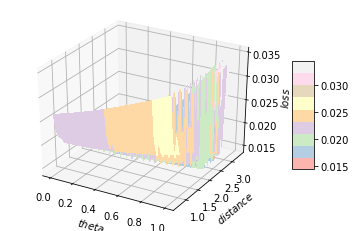

In [43]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.Pastel1,
                       linewidth=0, antialiased=False)
ax.set_xlabel('$theta$')
ax.set_ylabel('$distance$')
ax.set_zlabel('$loss$')
# Customize the z axis.
# ax.set_xlim(0.051, 0.054)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# ax.view_init(0, 180)
# ax.view_init(0, 0)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('fig1.png')
plt.show()

#### When \theta = 0.5 how was the aggregation benefit got affected?
*aggregation benefit*: (the accuracy of the aggregated model) - (accuracy of the better local model)

In [47]:
Y.shape

(190, 21)

In [49]:
Z.shape

(190, 21)

In [55]:
Z[:,theta_index].shape

(190,)

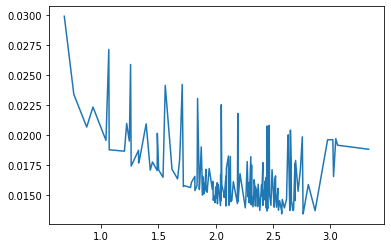

In [56]:
theta_index = 10
B = np.zeros(Z.shape[0])
B = Z[:,theta_index] - np.max(Z[:,0] - Z[:,1])
B_y = np.array(sorted(dist_list))
plt.plot(B_y, B)
plt.show()